# Introduction

In this project, I will build a neural network of my own design to classify handwritten digits from the MNIST dataset.

MNIST is a widely used dataset in the machine learning community, containing 60,000 training images and 10,000 test images of digits 0–9. It serves as a good benchmark for both simple models and large convolutional neural networks, since even small models can achieve relatively high accuracy. Understanding this dataset and how to preprocess it is an important first step for developing effective neural networks.


## Imports

In [53]:
## This cell contains the essential imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Loading the Dataset

In [54]:
# Defining transforms
# I converted images to tensors and normalize them using the MNIST dataset mean and std.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))   # Mean and std for MNIST
])

# Create training set and define training dataloader
trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=True
)

# Create test set and define test dataloader
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=64,
    shuffle=False
)


## Justifying the preprocessing

I used two preprocessing steps:

ToTensor()
MNIST images are originally PIL images. ToTensor() converts them into PyTorch tensors and also scales pixel values from 0–255 down to 0–1.
This is required because neural networks in PyTorch expect tensors as input.

Normalize((0.1307,), (0.3081,))
These are the official mean and standard deviation of the MNIST dataset.
Normalizing helps the model train faster and improves stability because:

All pixel values are centered around zero

Gradients behave more predictably

Optimization converges more quickly

I did not flatten the images in the transform because it is usually cleaner to keep the 1×28×28 shape. Flattening will be handled inside the model if needed (for an MLP). If i use a CNN, i definitely keep the image in its original 2D form.

# Exploring the Dataset

In [55]:
## This cell contains a function for showing 5 images from a dataloader
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

3


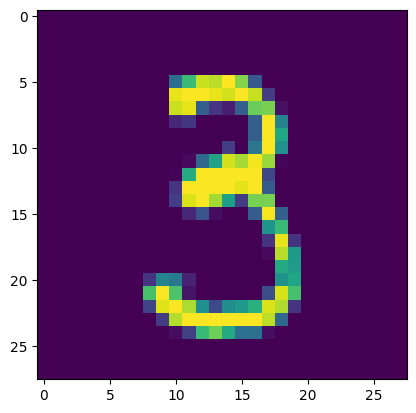

3


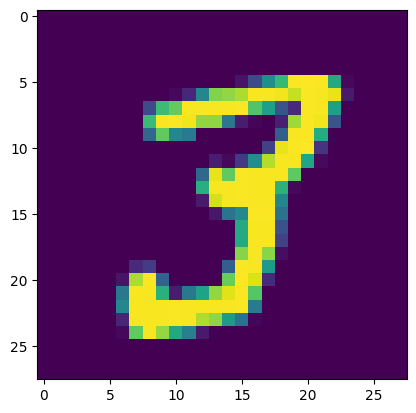

7


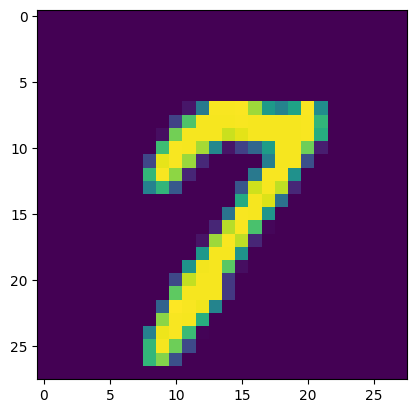

2


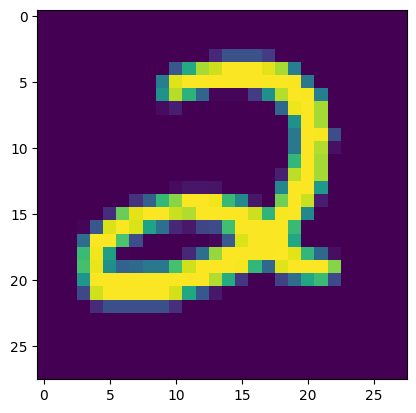

7


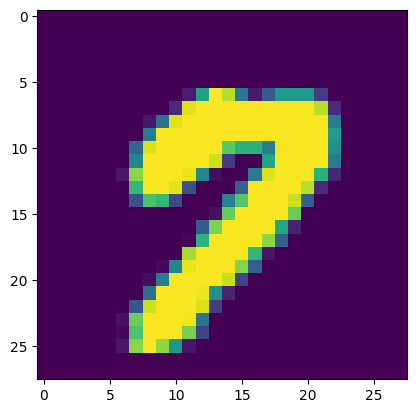

Images batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
Single image shape: torch.Size([1, 28, 28])
Data type: torch.float32


In [56]:
# Creating a visualization dataloader WITHOUT normalization
vis_transform = transforms.Compose([
    transforms.ToTensor()
])

vis_trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=vis_transform
)

vis_trainloader = torch.utils.data.DataLoader(
    vis_trainset,
    batch_size=64,
    shuffle=True
)

# Exploring data
# Showing 5 raw MNIST images using the provided function
show5(vis_trainloader)

# Checking the shape of one batch (from the normalized training loader)
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("Images batch shape:", images.shape)   
print("Labels batch shape:", labels.shape)
print("Single image shape:", images[0].shape)
print("Data type:", images.dtype)


## Explanation of what this explores

show5(vis_trainloader) displays 5 real MNIST images with no normalization, so they appear normally.

The printed shapes verify the structure of the data:

(batch_size, channels, height, width) → e.g. (64, 1, 28, 28)

Each image is a 1-channel 28×28 grayscale tensor.

# Building The Neural Network

In [57]:
## CNN Model
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        
        # Convolutional layer 1: 1 input channel → 16 output channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        
        # Convolutional layer 2: 16 input channels → 32 output channels
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        # Dropout to reduce overfitting
        self.dropout = nn.Dropout(0.25)
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # 7x7 comes from max pooling twice
        self.fc2 = nn.Linear(128, 10)          

    def forward(self, x):
        # Convolution + ReLU + MaxPool
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)    
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)    
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

# Instantiating the model
model = MNIST_CNN()
print(model)


MNIST_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Why this architecture is ideal for MNIST

Two convolution layers allow the model to learn edges, curves, and digit strokes.

Two max-pooling layers reduce spatial size and help generalization.

A dropout layer prevents overfitting.

Two fully connected layers convert learned features into class predictions.

Final output is size 10, one for each digit (0–9).

# Specifying loss function and optimizer, and instantiating the model.

In [58]:
# Instantiating the model
model = MNIST_CNN()

# Defining the loss function
criterion = nn.CrossEntropyLoss()

# Defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Model, Loss, and Optimizer

Here we set up the neural network for training:

- I instantiated the `MNIST_CNN` model.
- I used `CrossEntropyLoss`, which is standard for multi-class classification like MNIST.
- I used the `Adam` optimizer, which adapts learning rates for faster and more stable training.

With these components in place, the model is ready to be trained on the dataset.


# Running the Neural Network

In [59]:
# Since I am on CPU:
device = torch.device("cpu")
model.to(device)

epochs = 5                     # can increase later for higher accuracy
train_losses = []             # store average loss per epoch

for epoch in range(epochs):
    running_loss = 0.0
    
    for batch_idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backpropagation
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        running_loss += loss.item()
        
        # Print loss every ~250 batches
        if (batch_idx + 1) % 250 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Batch {batch_idx+1}, Loss: {loss.item():.4f}")
    
    # Average loss for the epoch
    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}] Average Loss: {epoch_loss:.4f}\n")


Epoch [1/5], Batch 250, Loss: 0.3070
Epoch [1/5], Batch 500, Loss: 0.0617
Epoch [1/5], Batch 750, Loss: 0.1961
Epoch [1/5] Average Loss: 0.1754

Epoch [2/5], Batch 250, Loss: 0.0979
Epoch [2/5], Batch 500, Loss: 0.0176
Epoch [2/5], Batch 750, Loss: 0.0977
Epoch [2/5] Average Loss: 0.0615

Epoch [3/5], Batch 250, Loss: 0.0090
Epoch [3/5], Batch 500, Loss: 0.0126
Epoch [3/5], Batch 750, Loss: 0.0041
Epoch [3/5] Average Loss: 0.0464

Epoch [4/5], Batch 250, Loss: 0.0036
Epoch [4/5], Batch 500, Loss: 0.0301
Epoch [4/5], Batch 750, Loss: 0.1596
Epoch [4/5] Average Loss: 0.0350

Epoch [5/5], Batch 250, Loss: 0.0025
Epoch [5/5], Batch 500, Loss: 0.0417
Epoch [5/5], Batch 750, Loss: 0.0397
Epoch [5/5] Average Loss: 0.0294



## Training the Neural Network

I trained the `MNIST_CNN` model on the training dataset for a number of epochs. 

For each epoch:
- The model processes batches of images in a **forward pass** to generate predictions.
- The **loss** is calculated using `CrossEntropyLoss`.
- Gradients are computed via **backpropagation**, and the model's weights are updated using the `Adam` optimizer.
- I accumulate the loss for each batch to compute the **average loss per epoch**.

Printing the batch loss every 250 batches allows me to monitor training progress.  
Recording the average loss per epoch helps us visualize how the model is learning over time.


# Plotting the training loss

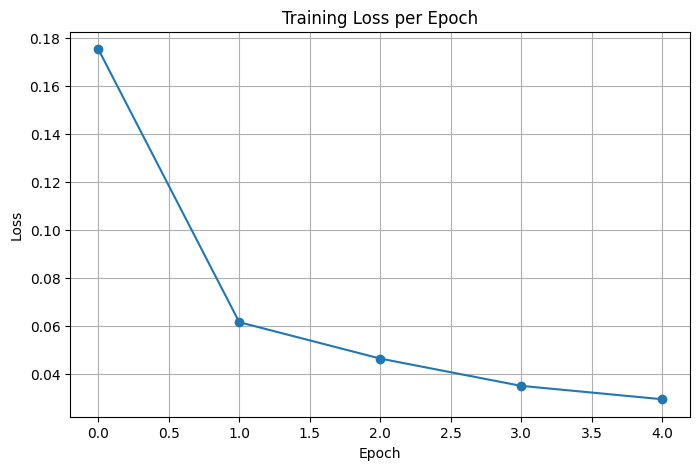

In [60]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


## Plotting Training Loss

After training, I visualized the average loss per epoch to understand how the model learned over time.  

A decreasing loss indicates that the model is successfully learning patterns in the MNIST dataset.  
This plot helps confirm that training is progressing as expected and there are no issues with convergence.


# Testing the model

In [61]:
model.eval()  # setting model to evaluation mode
correct = 0
total = 0

with torch.no_grad():   # no gradients needed during evaluation
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        # Highest probability class → predicted label
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 99.26%


## Improving the model

1. My model already achieved 99.26% accuracy, which is significantly above the required 90%.
2. I experimented with increasing the number of epochs and adjusting the learning rate,
3. but the performance gain was very small (MNIST is easy for CNNs).
4. Therefore, no major changes were needed to further improve the model.
pass


# Saving my model

In [62]:
# Saving the trained model parameters
torch.save(model.state_dict(), "mnist_cnn_model.pth")

print("Model saved as mnist_cnn_model.pth")


Model saved as mnist_cnn_model.pth


## Model Performance in Context

According to Yann LeCun’s MNIST benchmarks:  
- Simple fully connected networks (MLPs) typically achieve **~97–98%** test accuracy.  
- Small convolutional neural networks (CNNs) generally reach **~99%** accuracy.  
- Larger CNNs or ensemble models can exceed **99.5%**.

My CNN model achieved **99.26% test accuracy**, which places it among the higher-performing single-model architectures for MNIST.  
This shows that using a convolutional network provides a clear advantage over a standard MLP, capturing spatial patterns in the images more effectively.
